<a href="https://colab.research.google.com/github/farhanarrafi/proto-language-reconstruction-using-bengali-dialects/blob/main/colab/Proto_language_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [61]:
import os.path
import json
import pandas as pd
#from datasets import Dataset
#from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, accuracy_score, matthews_corrcoef, f1_score
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.pandas()


api_token = {"username":"farhanarrafi","key":"4f070f664abbd64c4eed43162a528d02"}


# https://stackoverflow.com/a/57401752/3148856
if not os.path.isdir('/root/.kaggle'):
  ! mkdir ~/.kaggle
  ! touch ~/.kaggle/kaggle.json
  with open('/root/.kaggle/kaggle.json', 'w') as file:
      json.dump(api_token, file)
  !chmod 600 ~/.kaggle/kaggle.json

#! kaggle datasets list

### Download Dataset

In [ ]:
if not os.path.isfile('BanglaDial.csv'):
    ! kaggle datasets download -d farhanarrafi/bangladial-a-dataset-for-bengali-dialect-analysis
    ! unzip bangladial-a-dataset-for-bengali-dialect-analysis.zip
    ! rm -rf bangladial-a-dataset-for-bengali-dialect-analysis.zip

Dataset URL: https://www.kaggle.com/datasets/farhanarrafi/bangladial-a-dataset-for-bengali-dialect-analysis
License(s): CC-BY-SA-4.0
Archive:  bangladial-a-dataset-for-bengali-dialect-analysis.zip
  inflating: BanglaDial.csv          
  inflating: BanglaDial.xlsx         
  inflating: BanglaDial_ A Merged and Imbalanced text Dataset for Bengali Regional dialect analysis. - Sheet1.csv  
  inflating: BanglaDial_ A Merged and Imbalanced text Dataset for Bengali Regional dialect analysis..xlsx  


In [ ]:



bangladial_dataset = pd.read_csv('BanglaDial.csv')

In [ ]:
bangladial_dataset.head()

,Sentence,Language
0,কেমন আছো ?,Standard_Bangla
1,আজকে আমার মন ভালো নেই,Standard_Bangla
2,তুমি কি করো ?,Standard_Bangla
3,এই গরমে আমার কিছু ভালো লাগে না,Standard_Bangla
4,ছেলেটি সাদা রঙয়ের একটি শার্ট পরে এসেছিল,Standard_Bangla


In [ ]:
bangladial_languages = bangladial_dataset['Language'].unique()

In [ ]:
bangladial_dataset.shape

(63303, 2)

In [ ]:
# bangladial_dataset['row'] = bangladial_dataset.groupby('Language').cumcount()

# # Pivot the table
# bangladial = bangladial_dataset.pivot(index='row', columns='Language', values='Sentence')

# # Optional: reset index if you want a clean DataFrame
# bangladial = bangladial.reset_index(drop=True)


In [ ]:
bangladial = bangladial_dataset
bangladial.head(10)

,Sentence,Language
0,কেমন আছো ?,Standard_Bangla
1,আজকে আমার মন ভালো নেই,Standard_Bangla
2,তুমি কি করো ?,Standard_Bangla
3,এই গরমে আমার কিছু ভালো লাগে না,Standard_Bangla
4,ছেলেটি সাদা রঙয়ের একটি শার্ট পরে এসেছিল,Standard_Bangla
5,মেয়েটি লাল রঙয়ের শাড়ি পরে আমার সাথে দেখা করতে ...,Standard_Bangla
6,ছেলেটি সিলেট থেকে ঢাকায় এসেছে,Standard_Bangla
7,মেয়েটি সিলেট থেকে আসা এই ছেলেটিকে অনেক ভালবাসে,Standard_Bangla
8,ছেলেটি মেয়েটাকে এখনো ভালবাসার চোখে দেখেনি,Standard_Bangla
9,মেয়েটি তাঁর সব স্বপ্নের মধ্যে ছেলেটাকে কল্পনা করে,Standard_Bangla


In [ ]:
if not os.path.isfile('Vashantor/Final/Classification.csv'):
    ! kaggle datasets download -d raiyanzannat/vashantor
    ! unzip vashantor.zip
    ! rm -rf vashantor.zip

Dataset URL: https://www.kaggle.com/datasets/raiyanzannat/vashantor
License(s): apache-2.0
Archive:  vashantor.zip
  inflating: Vashantor/Combined/Barishal_Combined_Translation.csv  
  inflating: Vashantor/Combined/Chittagong_Combined_Translation.csv  
  inflating: Vashantor/Combined/Mymensingh_Combined_Translation.csv  
  inflating: Vashantor/Combined/Noakhali_Combined_Translation.csv  
  inflating: Vashantor/Combined/Sylhet_Combined_Translation.csv  
  inflating: Vashantor/Final/Barishal.csv  
  inflating: Vashantor/Final/Chittagong.csv  
  inflating: Vashantor/Final/Classification.csv  
  inflating: Vashantor/Final/Mymensingh.csv  
  inflating: Vashantor/Final/Noakhali.csv  
  inflating: Vashantor/Final/Sylhet.csv  


In [ ]:
vashantor_barishal = pd.read_csv('Vashantor/Final/Barishal.csv')
vashantor_chittagong = pd.read_csv('Vashantor/Final/Chittagong.csv')
vashantor_noakhali = pd.read_csv('Vashantor/Final/Noakhali.csv')
vashantor_mymensingh = pd.read_csv('Vashantor/Final/Mymensingh.csv')
vashantor_sylhet = pd.read_csv('Vashantor/Final/Sylhet.csv')

In [ ]:
vashantor_barishal.columns = vashantor_barishal.columns.str.strip()
vashantor_chittagong.columns = vashantor_chittagong.columns.str.strip()
vashantor_noakhali.columns = vashantor_noakhali.columns.str.strip()
vashantor_mymensingh.columns = vashantor_mymensingh.columns.str.strip()
vashantor_sylhet.columns = vashantor_sylhet.columns.str.strip()

In [ ]:
vashantor_barishal = vashantor_barishal.dropna()
vashantor_chittagong = vashantor_chittagong.dropna()
vashantor_noakhali = vashantor_noakhali.dropna()
vashantor_mymensingh = vashantor_mymensingh.dropna()
vashantor_sylhet = vashantor_sylhet.dropna()

In [ ]:
"""
  The format of the input text MUST BE: <district> <bengali_text>
"""
vashantor_barishal['combined'] = vashantor_barishal['region_name'] + ' ' + vashantor_barishal['regional_text']
vashantor_chittagong['combined'] = vashantor_chittagong['region_name'] + ' ' + vashantor_chittagong['regional_text']
vashantor_noakhali['combined'] = vashantor_noakhali['region_name'] + ' ' + vashantor_noakhali['regional_text']
vashantor_mymensingh['combined'] = vashantor_mymensingh['region_name'] + ' ' + vashantor_mymensingh['regional_text']
vashantor_sylhet['combined'] = vashantor_sylhet['region_name'] + ' ' + vashantor_sylhet['regional_text']

In [ ]:
vashantor_chittagong.head()

,regional_text,bangla_speech,region_name,combined
0,বাংলাদেশত ৬৪ ইয়ান জেলা,বাংলাদেশে ৬৪ টা জেলা,Chittagong,Chittagong বাংলাদেশত ৬৪ ইয়ান জেলা
1,আরা বেয়াক্কুন গতহালিয়া বাইরে গেইলাম,আমরা সবাই গতকাল বাহিরে গিয়েছিলাম,Chittagong,Chittagong আরা বেয়াক্কুন গতহালিয়া বাইরে গেইলাম
2,তোইয়ার হতা বলার ধরণ বহুত সুন্দর,তোমার কথা বলার ধরন অনেক সুন্দর,Chittagong,Chittagong তোইয়ার হতা বলার ধরণ বহুত সুন্দর
3,বরিশালর মানুষ হইল্লে অয় দে?,বরিশালের মানুষ কেমন হয়?,Chittagong,Chittagong বরিশালর মানুষ হইল্লে অয় দে?
4,খুলনা জেলা কি বহুত সুন্দর নাকি?,খুলনা জেলা কি অনেক সুন্দর?,Chittagong,Chittagong খুলনা জেলা কি বহুত সুন্দর নাকি?


In [ ]:
vashantor_barishal['combined'].str.len().max()

123

In [ ]:
# https://huggingface.co/teamapocalypseml/regben2ipa-byt5small
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("abdullaharean/regipa_bangla")
model = AutoModelForSeq2SeqLM.from_pretrained("abdullaharean/regipa_bangla")

In [ ]:
#text = "<district> bengali_text_here"
text = vashantor_barishal['combined'][2]
inputs = tokenizer(text, return_tensors='pt')
output_ids = model.generate(**inputs,
        max_length=128,   # or 256, depending on your text length
        num_beams=4,      # optional: makes output better (beam search)
        early_stopping=True)
print(tokenizer.decode(output_ids[0], skip_special_tokens=False))

<pad>bɐɾɔhɐl  t̪umɪ kɪ moɾe e͡ɪ̯ kɐmdɐ ko͡ɪ̯ɾɾɐ d̪et̪e pɐɾbɐ?</s>


In [ ]:
outputs = []

"""
  The format of the input text MUST BE: <district> <bengali_text>
"""
model = model.to(device)

def translate_text(text):
    inputs = tokenizer(text, return_tensors='pt').to(device)
    output_ids = model.generate(**inputs,
        max_length=128,   # or 256, depending on your text length
        num_beams=4,      # optional: makes output better (beam search)
        early_stopping=True)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)



In [ ]:
vashantor_barishal['ipa_output'] = vashantor_barishal['combined'].astype(str).apply(translate_text)

In [ ]:
vashantor_barishal.to_csv('vashantor_barishal_ipa.csv', index=False)

In [ ]:
vashantor_chittagong['ipa_output'] = vashantor_chittagong['combined'].astype(str).progress_apply(translate_text)

100%|██████████| 2499/2499 [30:11<00:00,  1.38it/s]


In [ ]:
vashantor_chittagong.to_csv('vashantor_chittagong_ipa.csv', index=False)

In [ ]:
vashantor_noakhali['ipa_output'] = vashantor_noakhali['combined'].astype(str).progress_apply(translate_text)
vashantor_noakhali.to_csv('vashantor_noakhali_ipa.csv', index=False)

100%|██████████| 2499/2499 [30:26<00:00,  1.37it/s]


In [ ]:
vashantor_mymensingh['ipa_output'] = vashantor_mymensingh['combined'].astype(str).progress_apply(translate_text)
vashantor_mymensingh.to_csv('vashantor_mymensingh_ipa.csv', index=False)

100%|██████████| 2499/2499 [30:41<00:00,  1.36it/s]


In [ ]:
vashantor_sylhet['ipa_output'] = vashantor_sylhet['combined'].astype(str).progress_apply(translate_text)
vashantor_sylhet.to_csv('vashantor_sylhet_ipa.csv', index=False)

100%|██████████| 2499/2499 [30:30<00:00,  1.36it/s]


In [ ]:
vashantor_barishal = pd.read_csv('vashantor_noakhali_ipa_with_bangla_ipa.csv')
vashantor_chittagong = pd.read_csv('vashantor_noakhali_ipa_with_bangla_ipa.csv')
vashantor_noakhali = pd.read_csv('vashantor_noakhali_ipa_with_bangla_ipa.csv')
vashantor_mymensingh = pd.read_csv('vashantor_noakhali_ipa_with_bangla_ipa.csv')
vashantor_sylhet = pd.read_csv('vashantor_noakhali_ipa_with_bangla_ipa.csv')

In [ ]:
#import epitran

# # Apply the transliteration function to the 'text' column
# df['bangla_speech_ipa'] = df['bangla_speech'].progress_apply(lambda x: epi_beng.transliterate(str(x)))

# df.to_csv('vashantor_sylhet_ipa_with_bangla_ipa.csv', index=False)

In [5]:
bangla_w_pie_root = pd.read_csv('bangla_with_pie_roots_reflex_index.csv')
bangla_without_pie_root = pd.read_csv('bangla_with_no_pie_root_matches_reflex_index.csv')

In [6]:
# Construct input strings from dialectal IPA
def generate_input(row):
    return (
        f"[standard] {row['bangla_speech_ipa']} "
        f"[barishal] {row['barishal_ipa']} "
        f"[sylhet] {row['sylhet_ipa']} "
        f"[mymensingh] {row['mymensingh_ipa']} "
        f"[noakhali] {row['noakhali_ipa']} "
        f"[chittagong] {row['chittagong_ipa']}"
    )

bangla_w_pie_root["input_text"] = bangla_w_pie_root.apply(generate_input, axis=1)
bangla_w_pie_root["target_text"] = bangla_w_pie_root["PIE_root"]

In [4]:
bangla_w_pie_root.head()

,bangla_speech_word,bangla_speech_ipa,barishal_word,barishal_ipa,sylhet_word,sylhet_ipa,mymensingh_word,mymensingh_ipa,noakhali_word,noakhali_ipa,chittagong_word,chittagong_ipa,english_translation,PIE_root,PIE_gloss,input_text,target_text
0,অনলাইনে,on̪l̪ain̪e,অনলাইনে,ɔnɔlɐ͡ɪ̯ne,অনলাইনো,ɔnɔlɐ͡ɪ̯no,অনলাইনে,ɔnɔlɐ͡ɪ̯ne,অনলাইনে,ɔnɔlɐ͡ɪ̯ne,অনলাইনত,ɔnɔlɐ͡ɪ̯nɔt̪o,Online,"e-neu̯en, neu̯n̥, enu̯n̥",nine,[standard] on̪l̪ain̪e [barishal] ɔnɔlɐ͡ɪ̯ne [s...,"e-neu̯en, neu̯n̥, enu̯n̥"
1,অন্ধকার,on̪d̪̤ɔkar,আন্ধার,ɐnd̪ʱɐɾ,আইন্দার,ɐ͡ɪ̯nd̪ɐɾ,অন্ধকার,ɔnd̪ʱokɐɾ,আন্ধকার,ɐnd̪ʱokɐɾ,অন্ধকার,ɔnd̪ʱokɐɾ,Dark,ku̯sep-,dark,[standard] on̪d̪̤ɔkar [barishal] ɐnd̪ʱɐɾ [sylh...,ku̯sep-
2,অন্ধকার,on̪d̪̤ɔkarɔ,আন্ধার,ɐnd̪ʱɐɾ,ভিতরটা,bʱɪt̪ɔɾtɐ,অন্ধকার,ɔnd̪ʱokɐɾ,ভিতরকান,bʱɪt̪ɔɾkɐn,বাড়ির,bɐɽɪɾ,Dark,ku̯sep-,dark,[standard] on̪d̪̤ɔkarɔ [barishal] ɐnd̪ʱɐɾ [syl...,ku̯sep-
3,অন্যতম,on̪d͡zɔt̪ɔmɔ,অন্যতম,ɔnnot̪ɔmo,হফরি,hofoɾɪ,অন্যতম,ɔnnot̪ɔmo,অন্যতম,ɔnnot̪ɔmo,অন্যতম,ɔnnot̪ɔmo,One,ast(h)-,bone,[standard] on̪d͡zɔt̪ɔmɔ [barishal] ɔnnot̪ɔmo [...,ast(h)-
4,অন্যদের,on̪d͡zɔd̪erɔ,অন্যগো,ɔnnogo,বুঝিয়া,buɟʱɪʲɐ,অন্যরারে,ɔnnoɾɐɾe,অন্যগো,ɔnnogo,আন্যদের,ɐnnod̪eɾ,Others,mātér-,mother,[standard] on̪d͡zɔd̪erɔ [barishal] ɔnnogo [syl...,mātér-


In [7]:
# Convert to Hugging Face dataset
dataset = Dataset.from_pandas(bangla_w_pie_root[["input_text", "target_text"]])

AttributeError: type object 'Dataset' has no attribute 'from_pandas'

In [24]:
# Tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/mt5-small").to(device)
model = T5ForConditionalGeneration.from_pretrained("google/mt5-small").to(device)

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


In [25]:
# Tokenization functions
def tokenize(batch):
    inputs = tokenizer(batch["input_text"], padding="max_length", truncation=True, max_length=128)
    targets = tokenizer(batch["target_text"], padding="max_length", truncation=True, max_length=32)
    inputs["labels"] = targets["input_ids"]
    return inputs

dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/452 [00:00<?, ? examples/s]

In [26]:
# Split into train/test (90/10)
split = dataset.train_test_split(test_size=0.1, seed=11)
train_dataset = split["train"]
eval_dataset = split["test"]

In [27]:
# TrainingArguments
training_args = TrainingArguments(
    output_dir="t5-pie",
    logging_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    save_total_limit=2,
    logging_dir="logs",
    report_to="none",  # turn off W&B
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

In [28]:
train_result = trainer.train()

Step,Training Loss
102,39.294200
204,26.570800
306,19.740800
408,15.638800
510,13.302300
612,11.716900
714,10.209700
816,9.379600
918,8.840200
1020,8.423700


In [35]:
def predict_proto(word_row):
    input_str = generate_input(word_row)
    inputs = tokenizer(input_str, return_tensors="pt", truncation=True, padding=True).to(device)
    output_ids = model.generate(**inputs, max_length=32).to(device)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

sample = bangla_w_pie_root.iloc[0]
print("Predicted PIE root:", predict_proto(sample))
print("Gold PIE root:", sample["PIE_root"])

Predicted PIE root: <extra_id_0>----o--s--,s ---s--̯̯
Gold PIE root: e-neu̯en, neu̯n̥, enu̯n̥


In [29]:
logs = trainer.state.log_history
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]

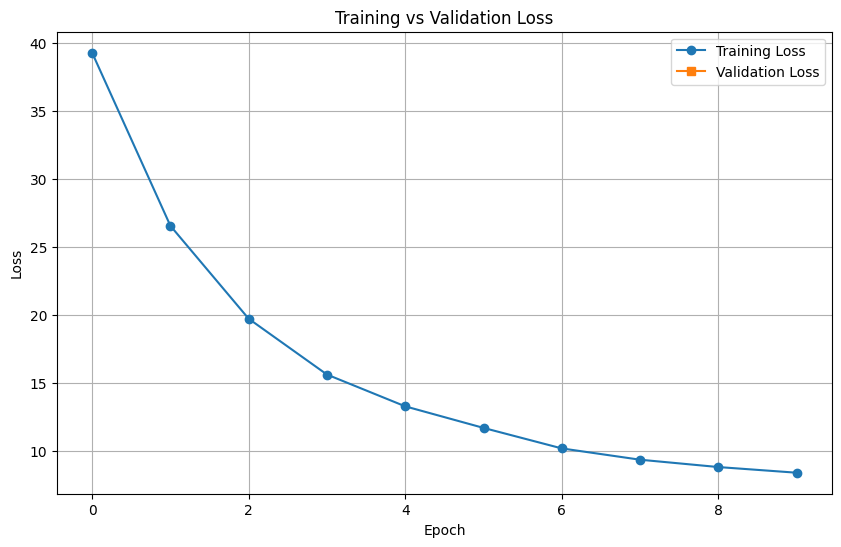

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training Loss", marker='o')
plt.plot(eval_loss, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [36]:
def get_predictions(dataset):
    predictions = []
    references = []
    for row in dataset:
        input_str = row["input_text"]
        inputs = tokenizer(input_str, return_tensors="pt", truncation=True).to(device)
        output_ids = model.generate(**inputs, max_length=32).to(device)
        prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        predictions.append(prediction)
        references.append(row["target_text"])
    return predictions, references

preds, refs = get_predictions(eval_dataset)

In [37]:
# Accuracy
exact_matches = [p == r for p, r in zip(preds, refs)]
acc = np.mean(exact_matches)
print(f"Exact Match Accuracy: {acc:.2f}")

Exact Match Accuracy: 0.00


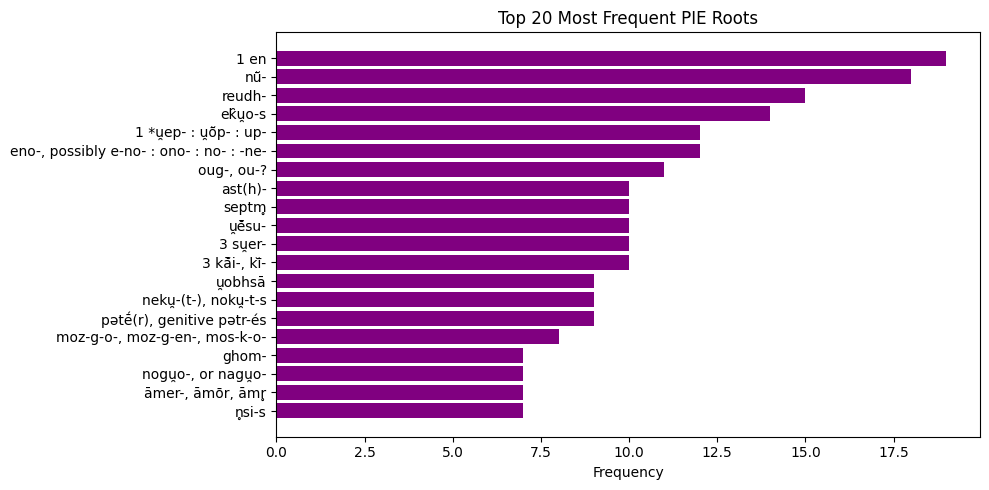

In [40]:
from collections import Counter

root_counts = Counter(bangla_w_pie_root["PIE_root"])
most_common = root_counts.most_common(20)

labels, values = zip(*most_common)
plt.figure(figsize=(10, 5))
plt.barh(labels, values, color='purple')
plt.gca().invert_yaxis()
plt.title("Top 20 Most Frequent PIE Roots")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

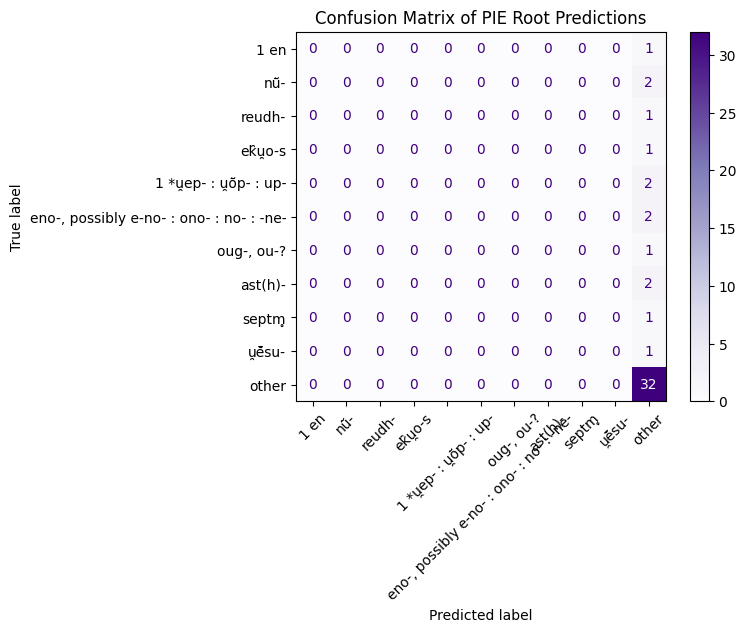

In [41]:
# Focus only on top N most frequent roots
top_roots = [r for r, c in most_common[:10]]
filtered_preds = [p if p in top_roots else "other" for p in preds]
filtered_refs = [r if r in top_roots else "other" for r in refs]

cm = confusion_matrix(filtered_refs, filtered_preds, labels=top_roots + ["other"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top_roots + ["other"])
disp.plot(xticks_rotation=45, cmap="Purples")
plt.title("Confusion Matrix of PIE Root Predictions")
plt.show()

In [8]:
bangla_w_pie_root = pd.read_csv('bangla_with_pie_roots_reflex_index.csv')
bangla_without_pie_root = pd.read_csv('bangla_with_no_pie_root_matches_reflex_index.csv')

In [9]:
bangla_w_pie_root.head()

,bangla_speech_word,bangla_speech_ipa,barishal_word,barishal_ipa,sylhet_word,sylhet_ipa,mymensingh_word,mymensingh_ipa,noakhali_word,noakhali_ipa,chittagong_word,chittagong_ipa,english_translation,PIE_root,PIE_gloss
0,অংশ,oŋɕɔ,অংশ,ɔŋʃo,অংশ,ɔŋʃo,অংশ,ɔŋʃo,অংশ,ɔŋʃo,অংশ,ɔŋʃo,Part,2c. per-,part
1,অঘটন,o̤ɡ̤ɔtɔn̪ɔ,অঘটন,ɔgʱɔton,অঘটন,ɔgʱɔton,অঘটন,ɔgʱɔton,অঘটন,ɔgʱɔton,দূর,d̪uɾ,Incident,1. k̑ad-,incident
2,অচেনা,ot͡ɕen̪a,অচেনা,ɔcenɐ,অচেনা,ɔcenɐ,অচেনা,ɔcenɐ,যেতাগোরে,ɟet̪ɐgoɾe,অচেনা,ɔcenɐ,Strange,eg̑hs,strange
3,অঞ্চল,ont͡ɕɔl̪ɔ,অঞ্চল,ɔncɔl,দু্র্যোগ,d̪uɾɟog,অঞ্চল,ɔncɔl,প্রভন,pɾobʱon,আঞ্চল,ɐncɔl,Region,1. reg̑-,region
4,অঞ্চলের,ont͡ɕɔl̪erɔ,এলাকার,elɐkɐɾ,জেগার,ɟegɐɾ,অঞ্চলের,ɔncoleɾ,অঞ্চলের,ɔncoleɾ,অঞ্চল,ɔncɔl,Region,1. reg̑-,region


In [10]:
bangla_w_pie_root.shape

(2403, 15)

In [64]:

inputs = []
targets = []

for _, row in bangla_w_pie_root.iterrows():
    ipa_array = [
        row['bangla_speech_ipa'],
        row['barishal_ipa'],
        row['sylhet_ipa'],
        row['mymensingh_ipa'],
        row['noakhali_ipa'],
        row['chittagong_ipa']
    ]
    inputs.append(ipa_array)
    targets.append(row['PIE_root'])

# Flatten the list of input arrays into a single list of strings
flattened_inputs = [''.join(ipa_array) for ipa_array in inputs]
#flattened_targets = [''.join(ipa_array_target) for ipa_array_target in targets]

# Combine all text from inputs and targets
all_text = ' '.join(flattened_inputs) + ''.join(targets)

# char_to_idx = {char: idx for idx, char in enumerate(sorted(vocab))}
# idx_to_char = {idx: char for char, idx in char_to_idx.items()}

# Build character-level vocabulary
vocab = set(all_text)
vocab.add(' ')
vocab_size = len(vocab)
char_to_idx = {char: idx for idx, char in enumerate(sorted(vocab))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [65]:
# Encode the inputs and targets
def encode_sequence(seq):
    return [char_to_idx[char] for char in seq if char in char_to_idx]

input_seqs = [encode_sequence(seq) for seq in inputs]
target_seqs = [encode_sequence(seq) for seq in targets]

# # Padding function to ensure equal length sequences
# def pad_sequence(sequences, max_len):
#     return [seq + [char_to_idx[' ']] * (max_len - len(seq)) for seq in sequences]

max_input_len = max([len(seq) for seq in input_seqs])
max_target_len = max([len(seq) for seq in target_seqs])

# input_seqs_padded = pad_sequence(input_seqs, max_input_len)
# target_seqs_padded = pad_sequence(target_seqs, max_target_len)

def pad_sequence(sequences, max_len, char_to_idx):
    return [seq + [char_to_idx[' ']] * (max_len - len(seq)) for seq in sequences]


# Pad sequences
padded_inputs = pad_sequence(input_seqs, max_input_len, char_to_idx)
padded_targets = pad_sequence(target_seqs, max_target_len, char_to_idx)

In [66]:
train_inputs, test_inputs, train_targets, test_targets = train_test_split(padded_inputs, padded_targets, test_size=0.1)

In [67]:
# Model definition
class Seq2SeqModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(Seq2SeqModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)  # Embedding layer
        self.encoder = nn.LSTM(hidden_size, hidden_size, num_layers=2, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, hidden_size, num_layers=2, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x, y=None):
        x = self.embedding(x)  # Apply embedding layer to input sequence

        # Encoder
        _, (h, c) = self.encoder(x)  # Encoder outputs

        # Decoder needs target sequence as input
        if y is not None:
            y = self.embedding(y)  # Apply embedding to the target sequence

        output, _ = self.decoder(y, (h, c))  # Decoder

        logits = self.output_layer(output)  # Output layer to predict the PIE root
        return logits


# Model initialization
hidden_size = 512
model = Seq2SeqModel(vocab_size, vocab_size, hidden_size)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # Ignore padding
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [68]:
# Prepare DataLoader
class CognateDataset(torch.utils.data.Dataset):
    def __init__(self, input_tensor, target_tensor):
        self.inputs = input_tensor
        self.targets = target_tensor

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # Make sure to return tensors
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.targets[idx], dtype=torch.long)

In [69]:
train_dataset = CognateDataset(train_inputs, train_targets)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

test_dataset = CognateDataset(test_inputs, test_targets)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [70]:
# Training loop
train_losses, val_losses = [], []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_inputs, batch_targets in train_loader:
        optimizer.zero_grad()

        # Forward pass
        output = model(batch_inputs, batch_targets)

        # Calculate loss
        loss = criterion(output.view(-1, vocab_size), batch_targets.view(-1))
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation step
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch_inputs, batch_targets in test_loader:
            output = model(batch_inputs, batch_targets)
            loss = criterion(output.view(-1, vocab_size), batch_targets.view(-1))
            val_loss += loss.item()
        val_losses.append(val_loss / len(test_loader))

    print(f'Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}')

Epoch 1: Train Loss = 0.0780, Val Loss = 0.0018
Epoch 2: Train Loss = 0.0006, Val Loss = 0.0013
Epoch 3: Train Loss = 0.0004, Val Loss = 0.0005
Epoch 4: Train Loss = 0.0002, Val Loss = 0.0000
Epoch 5: Train Loss = 0.0003, Val Loss = 0.0037
Epoch 6: Train Loss = 0.0007, Val Loss = 0.0001
Epoch 7: Train Loss = 0.0000, Val Loss = 0.0000
Epoch 8: Train Loss = 0.0001, Val Loss = 0.0000
Epoch 9: Train Loss = 0.0000, Val Loss = 0.0000
Epoch 10: Train Loss = 0.0000, Val Loss = 0.0000


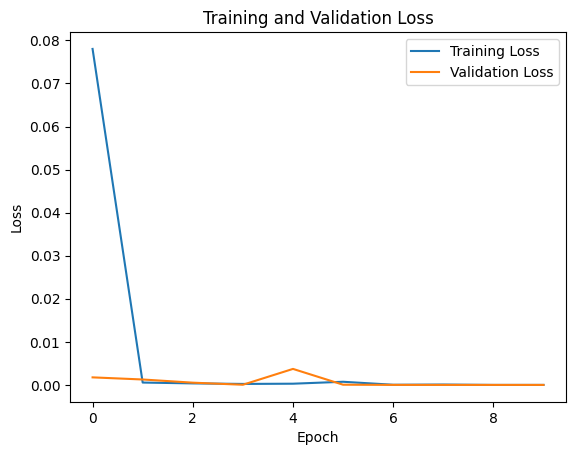

In [71]:
# Plotting the loss curves
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# Converts tensor indices to string
def decode_sequence(seq_tensor, idx_to_char):
    return [''.join([idx_to_char[idx.item()] for idx in seq if idx.item() != char_to_idx[' ']]) for seq in seq_tensor]


In [73]:
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch_inputs, batch_targets in test_loader:
        output = model(batch_inputs, batch_targets)  # shape: (batch_size, seq_len, vocab_size)
        predicted = output.argmax(dim=2)             # shape: (batch_size, seq_len)

        # Decode sequences into strings
        decoded_preds = decode_sequence(predicted, idx_to_char)
        decoded_targets = decode_sequence(batch_targets, idx_to_char)

        # Optional: keep only fully matching sequences (strict match)
        all_preds.extend(decoded_preds)
        all_targets.extend(decoded_targets)

In [74]:
# Flatten all characters
flat_preds = ''.join(all_preds)
flat_targets = ''.join(all_targets)

# Ensure lengths match
min_len = min(len(flat_preds), len(flat_targets))
flat_preds = flat_preds[:min_len]
flat_targets = flat_targets[:min_len]

# Convert characters to indices
char_set = list(set(flat_preds + flat_targets))
char_to_label = {ch: i for i, ch in enumerate(char_set)}

y_true = [char_to_label[c] for c in flat_targets]
y_pred = [char_to_label[c] for c in flat_preds]

# Compute metrics
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
MCC: 1.0000


Seq2SeqModel ends

### GRU with Attention Model

In [75]:
batch_size = 8

# Split into train and validation sets (80/20 split)
train_inputs, val_inputs, train_targets, val_targets = train_test_split(padded_inputs, padded_targets, test_size=0.2, random_state=42)

train_input_tensor = torch.tensor(train_inputs, dtype=torch.long)
train_target_tensor = torch.tensor(train_targets, dtype=torch.long)
val_input_tensor = torch.tensor(val_inputs, dtype=torch.long)
val_target_tensor = torch.tensor(val_targets, dtype=torch.long)

train_dataset = TensorDataset(train_input_tensor, train_target_tensor)
val_dataset = TensorDataset(val_input_tensor, val_target_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [76]:
def compute_metrics(y_true, y_pred):
    # Flatten and filter out ignored index (e.g. padding or ' ')
    y_true_flat = []
    y_pred_flat = []
    for true_seq, pred_seq in zip(y_true, y_pred):
        for t, p in zip(true_seq, pred_seq):
            if t != char_to_idx[' ']:
                y_true_flat.append(t)
                y_pred_flat.append(p)

    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    mcc = matthews_corrcoef(y_true_flat, y_pred_flat)
    return accuracy, precision, recall, f1, mcc

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assumed preprocessed variables
# input_seqs_padded: list of input sequence indices
# target_seqs_padded: list of target sequence indices
# char_to_idx, idx_to_char: vocab mappings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class GRUAttentionModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.encoder = nn.GRU(hidden_size, hidden_size, num_layers=4, dropout=dropout,  batch_first=True)
        self.decoder = nn.GRU(hidden_size + hidden_size, hidden_size, num_layers=4, dropout=dropout,  batch_first=True)
        self.output = nn.Linear(hidden_size, vocab_size)

    def forward(self, src, tgt):
        batch_size, tgt_len = tgt.size()

        embedded_src = self.dropout(self.embedding(src))
        embedded_tgt = self.dropout(self.embedding(tgt))

        encoder_outputs, hidden = self.encoder(embedded_src)

        outputs = torch.zeros(batch_size, tgt_len, self.hidden_size).to(src.device)
        decoder_hidden = hidden

        for t in range(tgt_len):
            decoder_input = embedded_tgt[:, t].unsqueeze(1)

            attn_weights = torch.bmm(decoder_input, encoder_outputs.transpose(1, 2))
            attn_weights = torch.nn.functional.softmax(attn_weights, dim=2)
            context = torch.bmm(attn_weights, encoder_outputs)

            rnn_input = torch.cat((decoder_input, context), dim=2)
            output, decoder_hidden = self.decoder(rnn_input, decoder_hidden)
            outputs[:, t] = output.squeeze(1)

        logits = self.output(outputs)
        return logits

hidden_size = 64
vocab_size = len(char_to_idx)
model = GRUAttentionModel(vocab_size, hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [78]:
num_epochs = 20
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_inputs, batch_targets in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)

        optimizer.zero_grad()
        output = model(batch_inputs, batch_targets)

        loss = criterion(output.view(-1, vocab_size), batch_targets.view(-1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    val_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for val_inputs_batch, val_targets_batch in val_loader:
            val_inputs_batch = val_inputs_batch.to(device)
            val_targets_batch = val_targets_batch.to(device)

            val_outputs = model(val_inputs_batch, val_targets_batch)
            loss = criterion(val_outputs.view(-1, vocab_size), val_targets_batch.view(-1))
            val_loss += loss.item()
            preds = val_outputs.argmax(dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(val_targets_batch.cpu().numpy())
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    acc, prec, rec, f1, mcc = compute_metrics(all_targets, all_preds)
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
    print(f"Metrics — Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}, MCC: {mcc:.4f}")

Epoch 1/20 | Train Loss: 1.4481 | Validation Loss: 1.0697
Metrics — Acc: 0.2492, Prec: 0.0278, Rec: 0.0659, F1: 0.0385, MCC: 0.1902
Epoch 2/20 | Train Loss: 0.8249 | Validation Loss: 0.6421
Metrics — Acc: 0.5077, Prec: 0.1196, Rec: 0.1747, F1: 0.1367, MCC: 0.4817
Epoch 3/20 | Train Loss: 0.5072 | Validation Loss: 0.3727
Metrics — Acc: 0.7250, Prec: 0.3416, Rec: 0.3560, F1: 0.3235, MCC: 0.7106
Epoch 4/20 | Train Loss: 0.2929 | Validation Loss: 0.1983
Metrics — Acc: 0.8943, Prec: 0.5381, Rec: 0.5540, F1: 0.5340, MCC: 0.8888
Epoch 5/20 | Train Loss: 0.1595 | Validation Loss: 0.1025
Metrics — Acc: 0.9552, Prec: 0.6445, Rec: 0.6379, F1: 0.6336, MCC: 0.9526
Epoch 6/20 | Train Loss: 0.0872 | Validation Loss: 0.0554
Metrics — Acc: 0.9765, Prec: 0.7062, Rec: 0.7092, F1: 0.7055, MCC: 0.9751
Epoch 7/20 | Train Loss: 0.0506 | Validation Loss: 0.0319
Metrics — Acc: 0.9907, Prec: 0.7923, Rec: 0.8056, F1: 0.7942, MCC: 0.9901
Epoch 8/20 | Train Loss: 0.0330 | Validation Loss: 0.0215
Metrics — Acc: 0.9

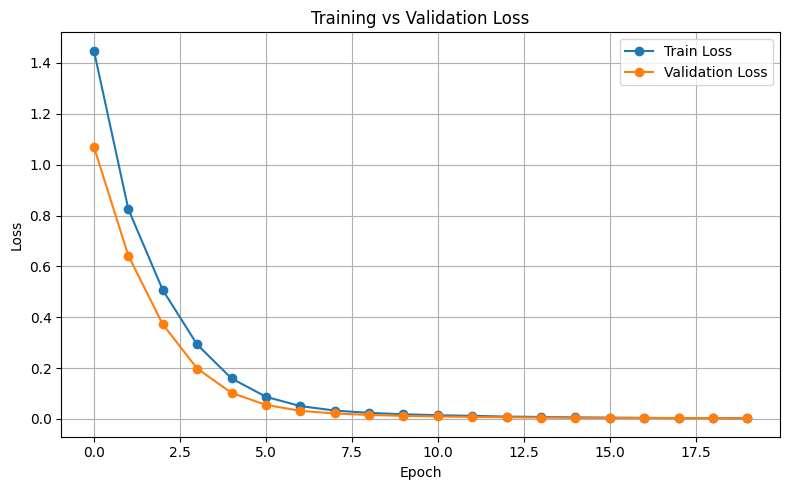

In [79]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [80]:
no_pie = bangla_without_pie_root.iloc[4]

inputs = no_pie['bangla_speech_ipa'] + " " + no_pie['barishal_ipa'] + " " + no_pie['sylhet_ipa'] + " " + no_pie['mymensingh_ipa'] + " " + no_pie['noakhali_ipa'] + " " + no_pie['chittagong_ipa']
targets = no_pie['PIE_root']

In [82]:
inputs

'on̪uprerna onupɾeɾonɐ cɔlɐɾ onupɾeɾonɐ onuheɾonɐ zɐ͡ɪ̯bɐɾ'

In [85]:
targets

np.float64(nan)

In [86]:
# oŋɕɔ,ɔŋʃo,ɔŋʃo,ɔŋʃo,ɔŋʃo,ɔŋʃo,  output: 2c. per-
#input: "t̪ɔ̃rɔ hɛɾ heɾ t̪ɐɾ heɾ t̪ɐ͡ɪ̯"  output: k̑o-
test_sequences = [
     "t̪ɔ̃rɔ hɛɾ heɾ t̪ɐɾ heɾ t̪ɐ͡ɪ̯"
]

In [91]:
def predict(model, sequences, char_to_idx, idx_to_char, device, max_len=30):
    model.eval()
    predictions = []

    for seq in sequences:
        # Preprocess: remove commas, spaces, and encode
        seq = seq.replace(",", " ")
        input_seq = [char_to_idx.get(char, char_to_idx[' ']) for char in seq]
        input_tensor = torch.tensor([input_seq], dtype=torch.long).to(device)

        with torch.no_grad():
            embedded = model.embedding(input_tensor)
            encoder_outputs, hidden = model.encoder(embedded)

            decoder_input = torch.tensor([[char_to_idx[' ']]], dtype=torch.long).to(device)
            output_chars = []

            for _ in range(max_len):
                decoder_emb = model.embedding(decoder_input)
                attn_weights = torch.bmm(decoder_emb, encoder_outputs.transpose(1, 2))
                attn_weights = torch.nn.functional.softmax(attn_weights, dim=2)
                context = torch.bmm(attn_weights, encoder_outputs)
                rnn_input = torch.cat((decoder_emb, context), dim=2)
                output, hidden = model.decoder(rnn_input, hidden)
                logits = model.output(output).squeeze(1)
                pred = logits.argmax(dim=1)
                pred_char = idx_to_char[pred.item()]
                if pred_char == ' ':
                    break
                output_chars.append(pred_char)
                decoder_input = pred.unsqueeze(1)

            predictions.append(''.join(output_chars))

    return predictions


In [92]:
outputs = predict(model, test_sequences, char_to_idx, idx_to_char, device)

print("\n--- Sample Predictions ---")
for seq, out in zip(test_sequences, outputs):
    print(f"Input: {seq} → Output: {out}")

Predicted char:  

--- Sample Predictions ---
Input: t̪ɔ̃rɔ hɛɾ heɾ t̪ɐɾ heɾ t̪ɐ͡ɪ̯ → Output: 
